Connect to drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Extract the data

In [ ]:
import tarfile

# Specify the file path
tar_file_path = "/content/drive/MyDrive/Brats_Dataset/Copy of BraTS2021_Training_Data.tar"

# Open the tar file
with tarfile.open(tar_file_path) as tar:
    # Extract all the contents to the current directory
    tar.extractall(path="/content/Brats")

Install TorchIO

In [ ]:
!pip install torchio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.8/175.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Import of all libs

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import nibabel as nib
from collections import defaultdict
from typing import Tuple, Sequence, List, Union, Dict

import torch

import SimpleITK as sitk

import torchio as tio

from torchio.data.io import nib_to_sitk
from torchio.data import Subject
from torchio.typing import TypeTripletFloat
from torchio.transforms.intensity_transform import IntensityTransform
from torchio.transforms.fourier import FourierTransform
from torchio.transforms.augmentation import RandomTransform

In [ ]:
# for file in os.listdir("/content/Brats"):

In [ ]:
os.mkdir("/content/pad_reor_data")
# os.mkdir("/content/drive/MyDrive/Brats_motion")
files = os.listdir("/content/Brats")

In [ ]:
import nibabel as nib
import numpy as np
# i=0
for file in files:
  if file[0] == "B":
    # print("gg")
    # i += 1
    # Load the NIfTI file
    img = nib.load(f"/content/Brats/{file}/{file}_t1.nii.gz")
# Load the MRI data
# img = nib.load(mri_file)

# Get the affine matrix
    affine = img.affine

    # Get the original orientation
    current_ornt = nib.io_orientation(affine)

    # Desired orientation ('R', 'A', 'S')
    desired_ornt = nib.orientations.axcodes2ornt(('R', 'A', 'S'))

    # Find the transformation to reorient the image
    transform = nib.orientations.ornt_transform(current_ornt, desired_ornt)

    # Apply the transformation to the image data and affine matrix
    reoriented_data = nib.orientations.apply_orientation(img.get_fdata(), transform)
    reoriented_affine = affine @ nib.orientations.inv_ornt_aff(transform, img.shape)

    # Create a new Nifti image
    reoriented_img = nib.Nifti1Image(reoriented_data, reoriented_affine)

    # Save the reoriented image (optional)
    # reoriented_img.to_filename(f"reor_data/reoriented_mri_file{file}.nii.gz")
    # print(f"The I is {i}")

    # Get and print the new orientation
    new_orientation = nib.aff2axcodes(reoriented_img.affine)
    # print(f"Converted Orientation of the MRI data: {reoriented_img.shape}")
    # print(f"Converted Orientation of the MRI data: {new_orientation}")
    desired_shape = (192, 256, 256)
    pad_before = [(max((d - s) // 2, 0)) for s, d in zip(reoriented_data.shape, desired_shape)]
    pad_after = [(max(d - (s + b), 0)) for s, d, b in zip(reoriented_data.shape, desired_shape, pad_before)]
    pad_width = list(zip(pad_before, pad_after))
    padded_data = np.pad(reoriented_data, pad_width, mode='constant', constant_values=0)

# Create a new Nifti image with padded data
    padded_affine = reoriented_affine  # Affine may need adjustment if padding affects spatial coordinates
    padded_img = nib.Nifti1Image(padded_data, padded_affine)

# Save the padded, reoriented image (optional)
    padded_img.to_filename(f"/content/pad_reor_data/{file}_t1.nii.gz")

# Get and print the new orientation
    new_orientation = nib.aff2axcodes(padded_img.affine)
    # print(f"Converted Orientation of the MRI data: {new_orientation}")


In [ ]:
len(os.listdir("/content/pad_reor_data"))

1251

The I is 1


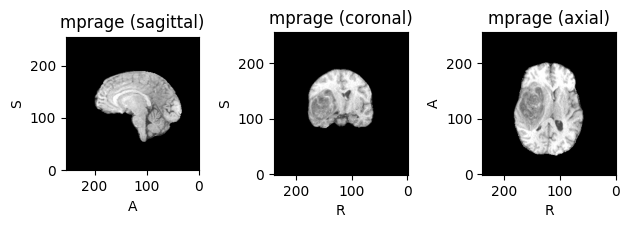

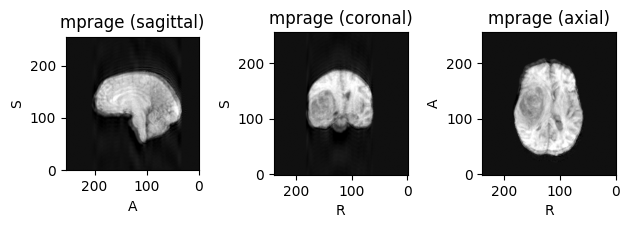

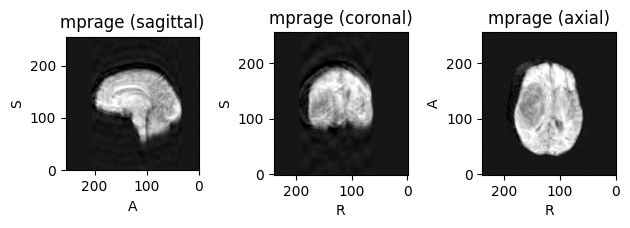

The I is 2


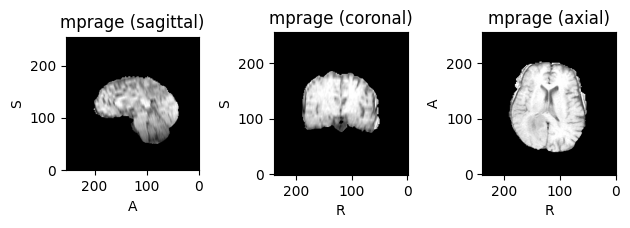

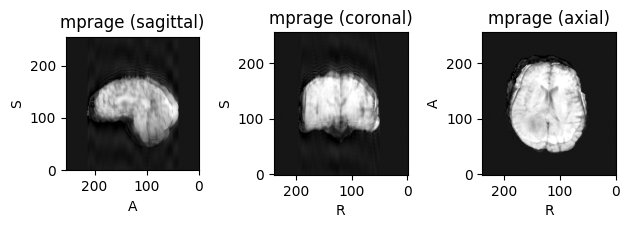

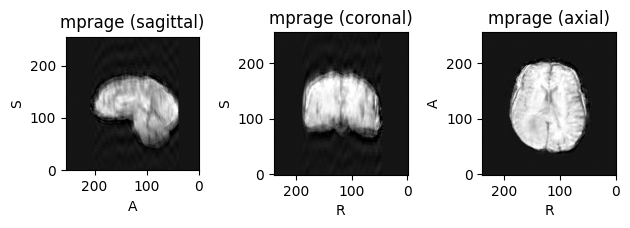

The I is 3


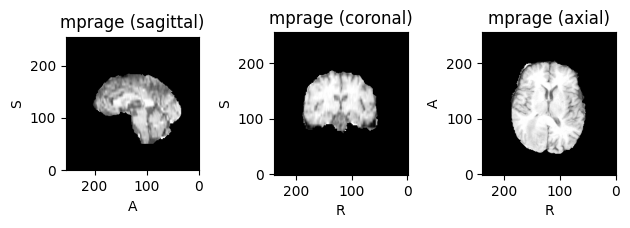

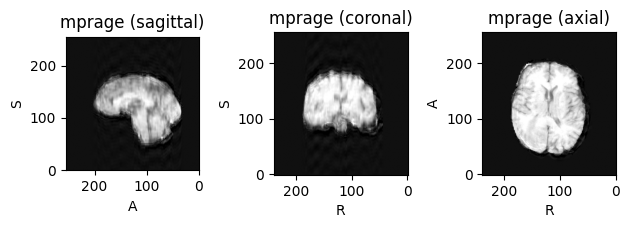

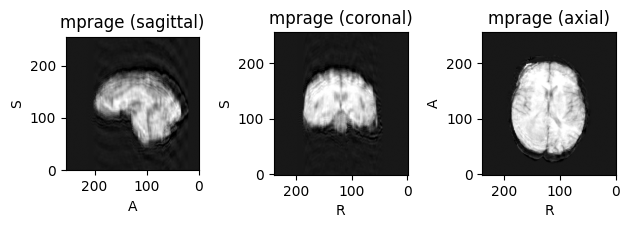

The I is 4


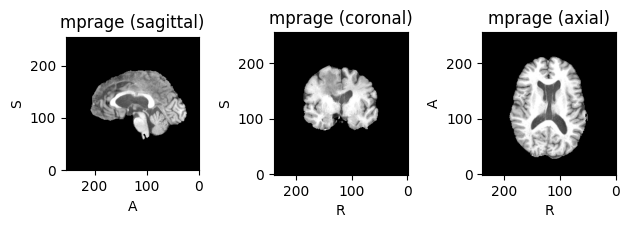

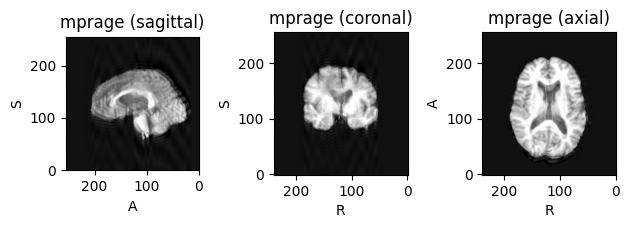

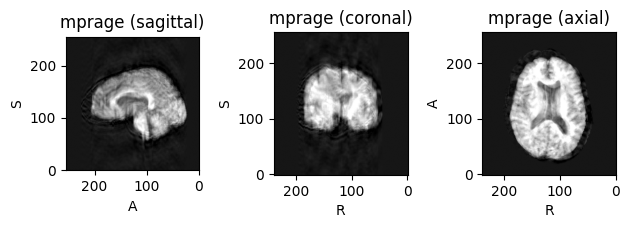

The I is 5


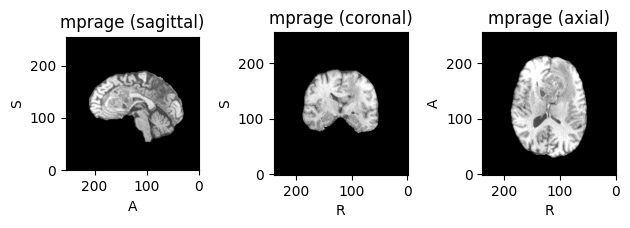

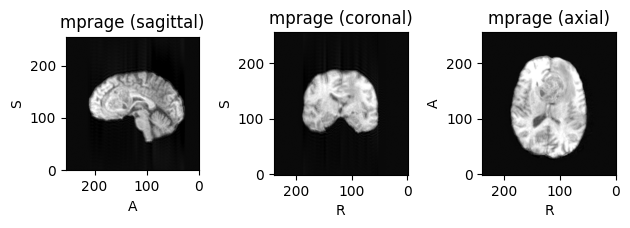

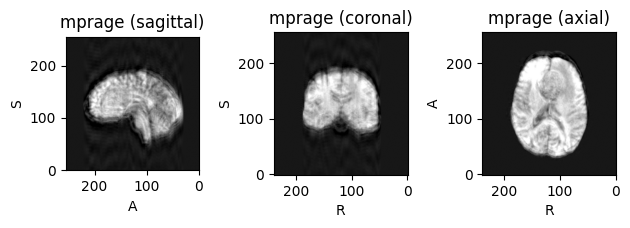

In [ ]:


# Define the motion transformation
motion_1 = tio.transforms.RandomMotion(
    degrees=3,  # Maximum rotation angle in degrees
    translation=5,  # Maximum translation in millimeters
    num_transforms=5,  # Number of transformations
    image_interpolation='linear',
)
motion_2 = tio.transforms.RandomMotion(
    degrees=3,  # Maximum rotation angle in degrees
    translation=5,  # Maximum translation in millimeters
    num_transforms=10,  # Number of transformations
    image_interpolation='linear',
)

# List files in the directory
files = os.listdir("/content/pad_reor_data")
i = 0
# Process each file
for file in files:
    i += 1
    print(f"The I is {i}")
    # Create a subject with the image
    normal_subject = tio.Subject(mprage=tio.ScalarImage(f"/content/pad_reor_data/{file}"))

    # Plot the original image (optional)
    normal_subject.plot()

    # Apply the motion transformation to the subject
    motion_subject1 = motion_1(normal_subject)
    motion_subject2 = motion_2(normal_subject)

    # Plot the transformed image (optional)
    motion_subject1.plot()
    motion_subject2.plot()
    if i == 5:
      break


In [ ]:
augmented_datasets1 = []
augmented_datasets2 = []
motion_1 = tio.transforms.RandomMotion(
    degrees=3,  # Maximum rotation angle in degrees
    translation=5,  # Maximum translation in millimeters
    num_transforms=5,  # Number of transformations
    # times=(0.2, 0.8),  # Start and end of motion artifacts as a fraction of total acquisition time
    image_interpolation='linear',
    )
motion_2 = tio.transforms.RandomMotion(
    degrees=3,  # Maximum rotation angle in degrees
    translation=5,  # Maximum translation in millimeters
    num_transforms=10,  # Number of transformations
    # times=(0.2, 0.8),  # Start and end of motion artifacts as a fraction of total acquisition time
    image_interpolation='linear',
    )
normal_subjects = []
no_sample = 1
for file in os.listdir("/content/pad_reor_data"):
  # /content/pad_reor_data/BraTS_t1BraTS2021_01572.nii.gz
  normal_subject = tio.Subject(mprage=tio.ScalarImage(f"/content/pad_reor_data/{file}"))
  # normal_subject.plot()
  # normal_subjects.append(normal_subject)
  # motion_subject1 = tio.SubjectsDataset(normal_subject,transform=motion_1)
  # motion_subject2 = tio.SubjectsDataset(normal_subject,transform=motion_2)
  motion_subject1 = motion_1(normal_subject)
  motion_subject2 = motion_2(normal_subject)
  os.mkdir(f"/content/drive/MyDrive/Brats_motion_data/{file}")
  motion_subject1.mprage.save(f"/content/drive/MyDrive/Brats_motion_data/{file}/{file}_t1_Motion1.nii.gz")
  motion_subject2.mprage.save(f"/content/drive/MyDrive/Brats_motion_data/{file}/{file}_t1_Motion2.nii.gz")
  print(f"saving sample {no_sample}")
  no_sample += 1
  # augmented_datasets.append(motion_subject1)
  # augmented_datasets1.append(motion_subject1)
  # augmented_datasets2.append(motion_subject2)


saving sample 1
saving sample 2
saving sample 3
saving sample 4
saving sample 5
saving sample 6
saving sample 7
saving sample 8
saving sample 9
saving sample 10
saving sample 11
saving sample 12
saving sample 13
saving sample 14
saving sample 15
saving sample 16
saving sample 17
saving sample 18
saving sample 19
saving sample 20
saving sample 21
saving sample 22
saving sample 23
saving sample 24
saving sample 25
saving sample 26
saving sample 27
saving sample 28
saving sample 29
saving sample 30
saving sample 31
saving sample 32
saving sample 33
saving sample 34
saving sample 35
saving sample 36
saving sample 37
saving sample 38
saving sample 39
saving sample 40
saving sample 41
saving sample 42
saving sample 43
saving sample 44
saving sample 45


KeyboardInterrupt: 